In [6]:
# Imports
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

import random

In [7]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [3]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [8]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


Random seed 2021 has been set.


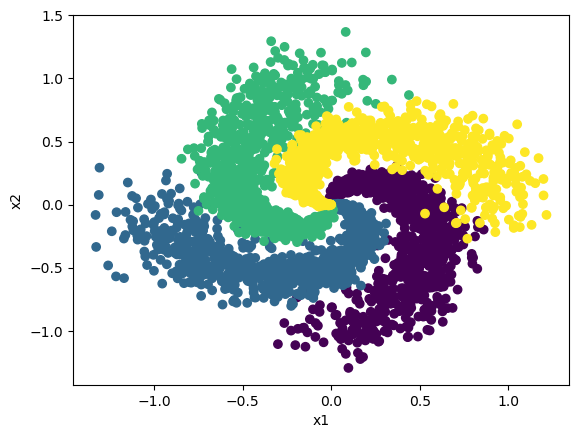

In [10]:
def create_spiral_dataset(K, sigma, N):
  """
  Function to simulate spiral dataset

  Args:
    K: int
      Number of classes
    sigma: float
      Standard deviation
    N: int
      Number of data points

  Returns:
    X: torch.tensor
      Spiral data
    y: torch.tensor
      Corresponding ground truth
  """

  # Initialize t, X, y
  t = torch.linspace(0, 1, N)
  X = torch.zeros(K*N, 2)
  y = torch.zeros(K*N)

  # Create data
  for k in range(K):
    X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
    X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
    y[k*N:(k+1)*N] = k

  return X, y


# Set parameters
K = 4
sigma = 0.16
N = 1000

set_seed(seed=SEED)
X, y = create_spiral_dataset(K, sigma, N)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [86]:
# @title Helper functions (MLP Tutorial 1 Codes)

# @markdown `Net(nn.Module)`

class Net(nn.Module):
  """
  Simulate MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: list
        Number of units per hidden layer. List of integers
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshapinng later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one
      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module(f"Linear_{i}", layer) # Append layer to the model with a name

      actv_layer = eval(f"nn.{actv}") # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module(f"Activation_{i}", actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # forward pass of MLP
    return logits


# @markdown `train_test_classification(net, criterion, optimizer, train_loader, test_loader, num_epochs=1, verbose=True, training_plot=False)`
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: Instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.to(device)
  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      criterion_function = eval(f"nn.{criterion}()")
      if (criterion == "MSELoss"):
        targets = torch.zeros((inputs.shape[0],4)) 
        for row in range(len(labels)):
            col = labels.int()[row]
            targets[row][col] = 1
        loss = criterion_function(outputs, targets)
      elif (criterion == "CrossEntropyLoss"):
        loss = criterion_function(outputs, labels)
      
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
        Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')
    print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc


# @markdown `shuffle_and_split_data(X, y, seed)`
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

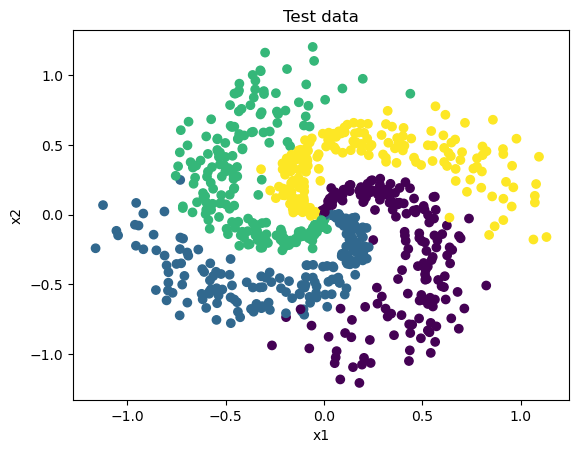

In [12]:
X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=SEED)
plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Test data')
plt.show()

In [78]:
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 1
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=seed_worker,
                          generator=g_seed)

Random seed 2021 has been set.


  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 64.91
Accuracy on the 800 testing samples: 68.38



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 87.62
Accuracy on the 800 testing samples: 87.50



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 92.59
Accuracy on the 800 testing samples: 92.12



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 91.38
Accuracy on the 800 testing samples: 91.88



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 93.03
Accuracy on the 800 testing samples: 91.25



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 94.50
Accuracy on the 800 testing samples: 93.00



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 93.75
Accuracy on the 800 testing samples: 93.12



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 95.03
Accuracy on the 800 testing samples: 94.00



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 97.50
Accuracy on the 800 testing samples: 97.12



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 94.66
Accuracy on the 800 testing samples: 93.00



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 95.12
Accuracy on the 800 testing samples: 95.00



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 95.41
Accuracy on the 800 testing samples: 94.62



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 97.84
Accuracy on the 800 testing samples: 97.50



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 96.06
Accuracy on the 800 testing samples: 95.38



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 97.06
Accuracy on the 800 testing samples: 96.12



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 94.59
Accuracy on the 800 testing samples: 93.50



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 95.38
Accuracy on the 800 testing samples: 94.88



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 96.12
Accuracy on the 800 testing samples: 94.75



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 92.94
Accuracy on the 800 testing samples: 93.62



  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 95.09
Accuracy on the 800 testing samples: 94.00



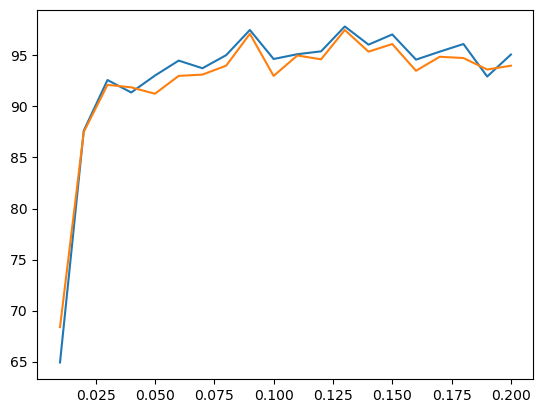

In [89]:
set_seed(SEED)
net = Net('ReLU()', X_train.shape[1], [128, 32], K).to(DEVICE)
# criterion = nn.CrossEntropyLoss()
criterion = "MSELoss"
# optimizer = optim.Adam(net.parameters(), lr=1e-3)
# optimizer = optim.SGD(net.parameters(), lr=2e-3)
num_epochs = 1

loss_history = []
learning_rates = np.arange(0.01, 0.2 + 0.01, 0.01)
for i in learning_rates:
    optimizer = optim.SGD(net.parameters(), lr=i)
    loss = train_test_classification(net, criterion, optimizer, train_loader,
                                    test_loader, num_epochs=num_epochs,
                                    training_plot=False, device=DEVICE)
    loss_history.append(loss)

plt.figure()
plt.plot(learning_rates, loss_history)

# _, _ = train_test_classification(net, criterion, optimizer, train_loader,
#                                  test_loader, num_epochs=num_epochs,
#                                  training_plot=True, device=DEVICE)

Random seed 2021 has been set.


  0%|          | 0/2 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 95.22
Accuracy on the 800 testing samples: 94.25



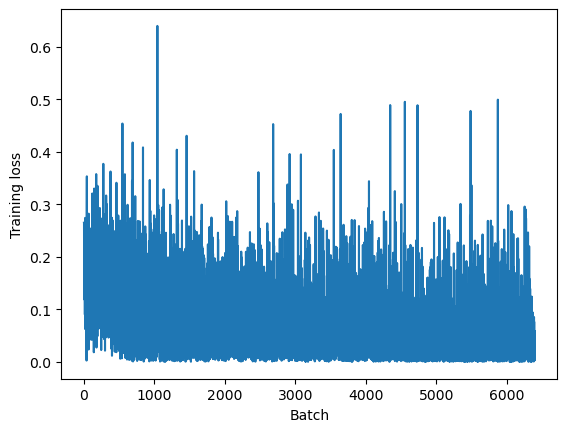

In [90]:
set_seed(SEED)
net = Net('ReLU()', X_train.shape[1], [128, 32], K).to(DEVICE)
# criterion = nn.CrossEntropyLoss()
criterion = "MSELoss"
# optimizer = optim.Adam(net.parameters(), lr=1e-3)
optimizer = optim.SGD(net.parameters(), lr=0.09)
num_epochs = 2

_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)

In [91]:
def sample_grid(M=500, x_max=2.0):
  """
  Helper function to simulate sample meshgrid

  Args:
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points

  Returns:
    X_all: torch.tensor
      Concatenated meshgrid tensor
  """
  ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max, M),
                          torch.linspace(-x_max, x_max, M),
                          indexing="ij")
  X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)
  return X_all


def plot_decision_map(X_all, y_pred, X_test, y_test,
                      M=500, x_max=2.0, eps=1e-3):
  """
  Helper function to plot decision map

  Args:
    X_all: torch.tensor
      Concatenated meshgrid tensor
    y_pred: torch.tensor
      Labels predicted by the network
    X_test: torch.tensor
      Test data
    y_test: torch.tensor
      Labels of the test data
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points
    eps: float
      Decision threshold

  Returns:
    Nothing
  """
  decision_map = torch.argmax(y_pred, dim=1)

  for i in range(len(X_test)):
    indices = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps
    decision_map[indices] = (K + y_test[i]).long()

  decision_map = decision_map.view(M, M)
  plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

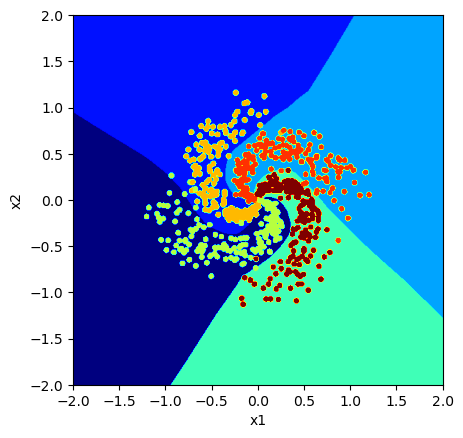

In [92]:
X_all = sample_grid()
y_pred = net(X_all.to(DEVICE)).cpu()
plot_decision_map(X_all, y_pred, X_test, y_test)

In [93]:
set_seed(SEED)
null_net = Net('ReLU()', X_train.shape[1], [128, 32], K).to(DEVICE)

Random seed 2021 has been set.


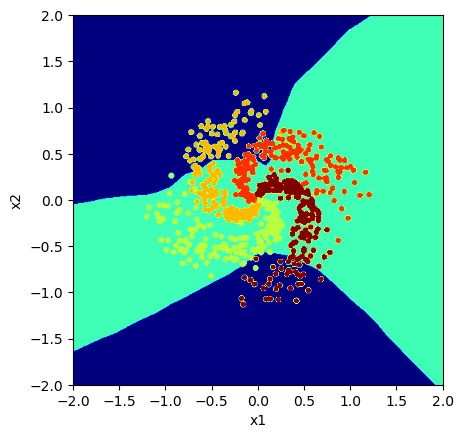

In [95]:
X_all = sample_grid()
y_pred = null_net(X_all.to(DEVICE)).cpu()
plot_decision_map(X_all, y_pred, X_test, y_test)

In [108]:
net.mlp[0].weight

Parameter containing:
tensor([[-0.6037,  0.0219],
        [ 0.4393,  0.3902],
        [ 0.0994, -0.4713],
        [-0.7374,  0.7349],
        [-0.2910, -0.5682],
        [ 0.4548, -0.5328],
        [ 0.4514, -0.5207],
        [ 0.4395, -0.1460],
        [ 0.0185, -0.2886],
        [ 0.4304,  0.3374],
        [ 0.4281, -0.2453],
        [ 0.6680,  0.0770],
        [-0.1842, -0.6930],
        [ 0.4904, -0.4700],
        [-0.5436, -0.2993],
        [ 0.3116,  0.3194],
        [ 0.5024,  0.0930],
        [ 0.2919,  0.5157],
        [-0.8369, -0.7039],
        [-0.8580, -0.5400],
        [ 0.2660,  0.6595],
        [ 0.2543, -0.4951],
        [ 0.3621,  0.4731],
        [ 0.8361, -0.9243],
        [-0.1055, -0.3966],
        [ 0.6116,  0.3844],
        [ 0.0855,  0.0441],
        [ 0.3614, -0.7182],
        [-0.0467, -0.6968],
        [ 0.1951,  0.2177],
        [-0.8323, -0.0332],
        [ 0.2947,  0.3648],
        [ 0.8450, -0.6685],
        [-0.2429, -0.2811],
        [-0.6721, -0.9149]